```
rawaudio -> mfcc -> encoder -> articulator -> mfcc -> mseloss
             |       |
             `-------`-------> discriminator
``` 

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from voice100_pinktrombone import PinkTrombone
pt = PinkTrombone(44)

In [402]:
x = normalize_control(data)
#x = unnormalize_control(x)

In [404]:
x.max(axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9646628 ,
       0.96163617, 0.95841081, 0.95497978, 0.95133647, 0.94747471,
       0.94338883, 0.93907371, 0.93481858, 0.93367309, 0.9325276 ,
       0.93138211, 0.93073704, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

/home/kaiida/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(219, 49)


(0.0, 1.5)

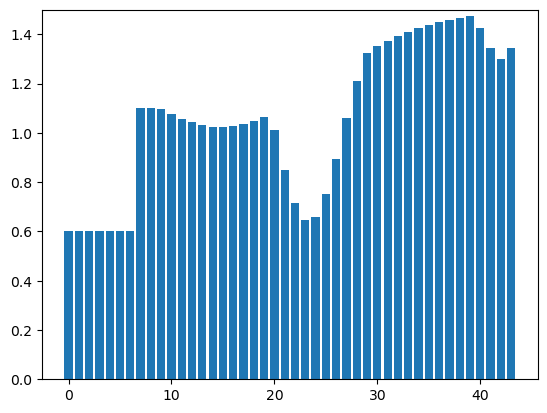

In [391]:
from train import generate_random_control

n = 44
T = 219
data = generate_random_control(T, n)
print(data.shape)
plt.bar(x=np.arange(n), height=data[40, 5:])
plt.ylim(0, 1.5)

(0.0, 1.5)

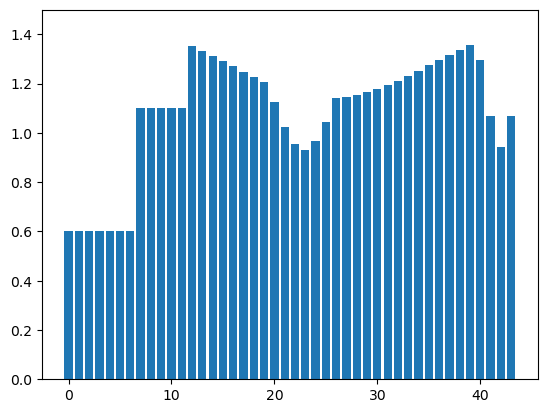

In [375]:
plt.bar(x=np.arange(n), height=diameter[100])
plt.ylim(0, 1.5)

In [367]:
data = np.concatenate([
    p[:, 5:],
    diameter
], axis=1)
data[:, 0] = 1.0 # data[:, 0] > 0.3
data[:, 1] = data[:, 1] * 100 + 100
#data[:, 3] = data[:, 2] ** 0.8
data[:, 2:4] = 1.0
data[:, 4] = np.clip(data[:, 4] * 0.4 - 0.2, 0.01, 0.2)
data.shape

(380, 49)

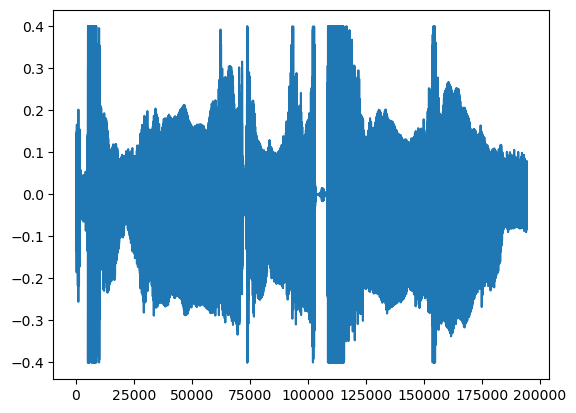

In [368]:
y = np.clip(pt(data), -.4, .4)
plt.plot(y)

In [369]:
import IPython.display as ipd
ipd.Audio(data=y, rate=44100)

<BarContainer object of 44 artists>

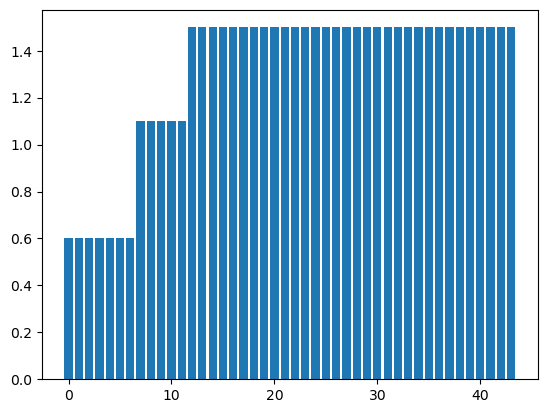

In [17]:
n = 44
data = rest_diameter(n)
plt.bar(x=np.arange(n), height=data)

<BarContainer object of 44 artists>

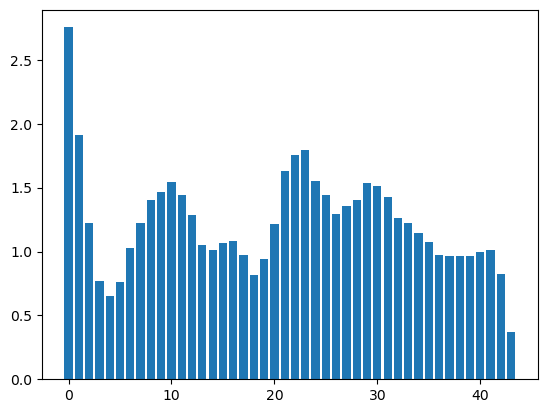

In [6]:
def dummy_data(N=44, T=2000, M=100):
    import numpy as np

    X = np.random.normal(size=(T, N + 5))
    w = np.hamming(M)
    w = w / np.sum(w)
    Y = X[M - 1:, :] * w[0]
    for i in range(1, M):
        # print(X[M-1-i:-i, :].shape)
        Y = Y + X[M-1-i:-i, :] * w[i]
    X = Y / np.std(Y)
    del Y

    X[:, 0] = X[:, 0] > -.1  # voiced
    X[:, 1] = np.clip(X[:, 1] * 40 + 160 + (44 - N) * ((220 - 160) / (44 - 38)), 80, 300)  # frequency
    X[:, 2:4] = np.clip(X[:, 2:4] * 0.5 + 0.7, 0.0, 1.0)  # tenseness
    X[:, 3] = X[:, 2] ** 0.8  # loudness
    X[:, 4] = np.clip(X[:, 4] * 0.1 + 0.01, 0.01, 0.2)  # velum
    X[:, 6:-1] = (X[:, 5:-2] + X[:, 6:-1] + X[:, 7:]) / 3.
    X[:, 6:-1] = (X[:, 5:-2] + X[:, 6:-1] + X[:, 7:]) / 3.
    X[:, 6:-1] = (X[:, 5:-2] + X[:, 6:-1] + X[:, 7:]) / 3.
    X[:, 5:] = np.clip(X[:, 5:] + 1.0, 0., 3.)

    return X

data = dummy_data()
plt.bar(x=np.arange(44), height=data[10, 5:])

In [1]:
import train
import importlib
importlib.reload(train)

from train import PinkTromboneModel
import torch
import torchaudio
from torch import nn

model = PinkTromboneModel(batch_size=4)

In [2]:
model = PinkTromboneModel.load_from_checkpoint('lightning_logs/version_8/checkpoints/last.ckpt')

In [10]:
model.setup("train")
dataloader = model.train_dataloader()
batch = next(iter(dataloader))

In [11]:
import IPython.display as ipd
ipd.Audio(data=batch[0], rate=22500)

In [189]:
from tqdm import tqdm
model.setup("train")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_loader = model.train_dataloader()
pbar = tqdm(train_loader)
for batch in pbar:
    x = model.compute_loss(batch)
    loss = x['rec_loss'] + x['est_loss']
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_postfix(
        rec_loss=x['rec_loss'].detach().cpu().item(),
        est_loss=x['est_loss'].detach().cpu().item(), end='')


  0%|          | 22/7135 [01:43<9:18:11,  4.71s/it, end=, est_loss=205, rec_loss=33.2] 


KeyboardInterrupt: 

In [13]:
targets = model.transform(batch)
x = model.encoder(targets)
estimates = model.decoder(x)
x = model.articulator(x).to(x.dtype).to(x.device)
x = torchaudio.functional.resample(x, 44100, 22050)
x = x / torch.max(torch.abs(x), axis=1, keepdim=True).values
audio = x
outputs = model.transform(x)
length = min(outputs.shape[2], targets.shape[2])
rec_loss = model.criterion(outputs[:, :, :length], targets[:, :, :length])
est_loss = model.criterion(outputs[:, :, :length], estimates[:, :, :length])


/home/ubuntu/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 124])) that is different to the input size (torch.Size([3, 32, 124])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [19]:
import IPython.display as ipd
ipd.Audio(data=audio[0], rate=44100)

In [62]:
loss = est_loss + rec_loss
loss

tensor(3521.7788, grad_fn=<AddBackward0>)

In [72]:
import IPython.display as ipd
ipd.Audio(data=outputs[9], rate=44100)

In [21]:
import IPython.display as ipd
ipd.Audio(data=batch[0], rate=22050)

In [50]:
batch.shape[1] / 256

126.0546875

In [47]:
x.shape

torch.Size([32, 32, 127])

In [10]:
import IPython.display as ipd
ipd.Audio(data=z, rate=16000)